# Differentially Private Point Patterns with GANs

## Setup

Install / load required dependencies

In [4]:
from IPython.display import clear_output
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import cuda, FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader

import datetime
import sys
import requests
import io
import os
import random
from time import sleep

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

Connect Google Drive to save models (only needed if models should be saved)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Use CUDA if GPU is available

In [6]:
# Use GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### GeoPointGAN - Code Base

In [16]:
###
# Large Spatial Transformer Network (STN) module
# 
# Input:
#   k = number of point dimensions
###
class STNkd(nn.Module):
    def __init__(self, k=2):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 32, 1)
        self.conv2 = torch.nn.Conv1d(32, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, 512, 1)
        self.conv5 = torch.nn.Conv1d(512, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)
        self.bn8 = nn.BatchNorm1d(128)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.fc2(x)))
        x = F.relu(self.bn8(self.fc3(x)))
        x = self.fc4(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)

        return x

###
# PointNet encoder
#
# Input:
#   code_nfts = number of point embedding dimensions
#   num_points = number of points 
#   n_dim = number of point dimensions
#   global_feat = if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNetfeat(nn.Module):
    """
        PointNet Module
    """
    def __init__(self, code_nfts=2048, num_points=2500, n_dim = 2, global_feat=True, trans=True):
        super(PointNetfeat, self).__init__()
        self.n_dim = n_dim
        self.stn = STNkd(k = n_dim)
        self.code_nfts = code_nfts
        self.conv1 = torch.nn.Conv1d(n_dim, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, code_nfts, 1)

        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(code_nfts)
        self.trans = trans

        self.num_points = num_points
        self.global_feat = global_feat

    def forward(self, x):
        if self.trans:
            trans = self.stn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans)
            x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x,_ = torch.max(x, 2)
        x = x.view(-1, self.code_nfts)
        if self.trans:
            if self.global_feat:
                return x #, trans
            else:
                x = x.view(-1, self.code_nfts, 1).repeat(1, 1, self.num_points)
                return torch.cat([x, pointfeat], 1), trans
        else:
            return x

###
# PointNet Generator
#
# Input:
#   code_nfts = number of point embedding dimensions
#   n_dim = number of point_dimensions
#   global_feat = argument for PointNet: if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = argument for PointNet: if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNet_Generator(nn.Module):
    """ 
        Generator with PointNet Encoder, MLP Decoder
    """
    def __init__(self, code_nfts=2048, n_dim=2, global_feat=True, trans=True):
        super(PointNet_Generator, self).__init__()
        self.code_nfts = code_nfts
        self.n_dim = n_dim
        self.encoder = nn.Sequential(
            PointNetfeat(code_nfts, 1, n_dim = n_dim, global_feat=global_feat, trans=trans),
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU(),
            nn.Linear(code_nfts, code_nfts // 2),
            nn.BatchNorm1d(code_nfts // 2),
            nn.ReLU(),
            nn.Linear(code_nfts // 2, n_dim),
            nn.Tanh()
        )


    def forward(self, x):
        #Encoder
        code = self.encoder(x)
        #Decoder
        x = self.decoder(code)
        x = x.view(-1, self.n_dim, 1)
        return x, code

###
# PointNet Discriminator
#
# Input:
#   code_nfts = number of point embedding dimensions
#   n_dim = number of point dimensions
#   global_feat = argument for PointNet: if True, return global feature embedding, if False, return individual (per-point) embeddings
#   trans = argument for PointNet: if True, use TransformNet implementation, if False, use Vanilla PointNet
###
class PointNet_Discriminator(nn.Module):
    """ 
        PointNet Discriminator
    """
    def __init__(self, code_nfts=2048, n_dim = 2, global_feat=True, trans = False):
        super(PointNet_Discriminator, self).__init__()
        self.n_dim = n_dim
        self.code_nfts = code_nfts
        self.cls = nn.Sequential(
            PointNetfeat(code_nfts, 1, n_dim = n_dim, global_feat=global_feat, trans=trans),
            nn.Linear(code_nfts, code_nfts),
            nn.BatchNorm1d(code_nfts),
            nn.ReLU(),
            nn.Linear(code_nfts, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        #Point level classifier
        x = self.cls(x)
        return x

Utilities

In [40]:
#Plotting
def get_sample_points(G, z, n_dim):
    """
      Generate 'size' data samples
      ___

      G = Generator (in G.eval() mode)
      z = Random noise tensor of shape (n, n_dim, 1)
    """
    z_gen,_ = G(z)
    z_gen = z_gen.permute(2,0,1)
    n = z_gen.shape[1]
    batch_size = z_gen.shape[0]
    y_hat = z_gen.reshape(n * batch_size, n_dim) 
    points = y_hat.cpu().data.numpy()
    return points

def norm(x):
  for i in range(x.shape[1]):
    x[:,i] = 2 * (x[:,i]-min(x[:,i]))/(max(x[:,i])-min(x[:,i])) - 1
  return x

def rand_point(x, num_points, draw_with_replacement=False):
  total_num_points = x.shape[0]
  n_dim = x.shape[1]
  if draw_with_replacement:
    idx = np.random.randint(low=0,high=total_num_points, size=num_points) # Draw with replacement
  else:
    idx = np.random.choice(total_num_points, num_points) # Draw without replacement
  sample = x[idx]
  return sample

## Download Data

In [9]:
url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/porto-test.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["x","y"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
po = c

url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/nyc-test.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["x","y"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
ny = c

url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/beijing-test.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["x","y"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
be = c

url="https://archive.ics.uci.edu/ml/machine-learning-databases/00246/3D_spatial_network.txt"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.columns = ["id","x","y","z"]
c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
c["z"] = 2 * (c["z"]-min(c["z"]))/(max(c["z"])-min(c["z"])) - 1
road = c[["x","y","z"]]

## Generate Data 

Get real and fake point samples.

In [44]:
dataset = "3d_road"
eps = -1

if dataset == "new_york":
  real = np.array(ny)
elif dataset == "porto":
  real = np.array(po)
elif dataset == "beijing":
  real = np.array(be)
elif dataset == "3d_road":
  real = np.array(road)

n_dim = real.shape[1]
num_points = 10000 #Number of points to generate!
z_test = torch.randn(num_points, n_dim, 1).to(DEVICE) 
G = torch.load('gdrive/My Drive/PNGAN/model/G_%s_eps%i.pkl.gz' % (dataset, eps) ) #Link to your generator!

with torch.no_grad():
  G.eval()
  fake = get_sample_points(G, z_test, n_dim)
  fake = norm(fake)

real = rand_point(real, num_points)

Plot points

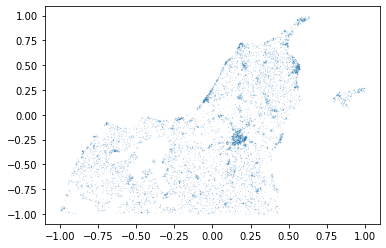

In [45]:
#Real points
plt.scatter(real[:,0],real[:,1],s=0.01,alpha=0.5)

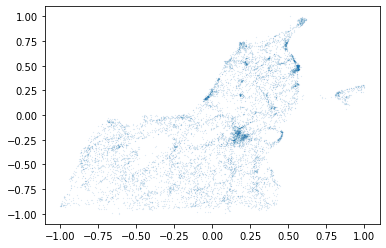

In [46]:
#Fake points
plt.scatter(fake[:,0],fake[:,1],s=0.01,alpha=0.5)